 #

# In516 Cursus project - SQL injection detection

#### Objective : Predict, using machine learning and deep learning, if a SQL query is a SQL injection attack or not.


# 1. Import the relevant libraries

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from spacy.compat import pickle
import seaborn as sns
import numpy as np
import itertools
import warnings

warnings.filterwarnings('ignore')

We open and read the data files. We can see that the dataset is composed of 2 columns : the first one is the query, the second one is the label (0 for benign and 1 for SQL injection attack).

In [3]:
df = pd.read_csv('data/Modified_SQL_Dataset.csv')

In [4]:
df.head()

,Query,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,AND 1 = utl_inaddr.get_host_address ( ...,1
3,select * from users where id = '1' or @ @1 ...,1
4,"select * from users where id = 1 or 1#"" ( ...",1


In [5]:
print('\nShape of train set:', df.shape)


Shape of train set: (30919, 2)


## 1 - Quick dataset analysis

Now that the dataset is imported in the jupyter file, we can start exploring, digging in the datas to see what it is composed of, understand the variables in it, the possible links between them, find the target etc. This step is very important because it allows the user to understand the meaning of datasets, see if information has to be changed, or removed and also start thinking about how datas should be used with the future implemented model.

### A) Dataset cleaning and verifications



First, we check if there are repetitions of observations in the dataset.

In [6]:
df = df.drop_duplicates()
print('Shape of train set:', df.shape)

Shape of train set: (30907, 2)


We can see that there were some repetitions in the dataset, so we removed them. Repetitions are not very good for the model because it can lead to overfitting and globally bias the model training.

### B) Analysis of the datasets

We can start by displaying some charcteristics in order to know the size of the dataset and what's inside.

In [7]:
columnNames = df.columns
datasetShape = df.shape
variablesTypes = df.dtypes
variablesTypesCount = df.dtypes.value_counts()

print('Column names:', columnNames, '\n')
print('Dataset shape:', datasetShape, '\n')
print('Variables types:', variablesTypes, '\n')
print('Variables types count:', variablesTypesCount)

Column names: Index(['Query', 'Label'], dtype='object') 

Dataset shape: (30907, 2) 

Variables types: Query    object
Label     int64
dtype: object 

Variables types count: object    1
int64     1
Name: count, dtype: int64


We can see that the dataset is composed of 2 columns : the first one is the query, the second one is the label (0 for benign and 1 for SQL injection attack).
The features are the queries and the target is the label. It's the value we want to predict.

### C) Analysis of the target variable

Repartition of the target:
 Label
0    19529
1    11378
Name: count, dtype: int64

Type of this variable: int64


[Text(0, 0, 'benign'), Text(0, 1, 'SQL injection attacks')]

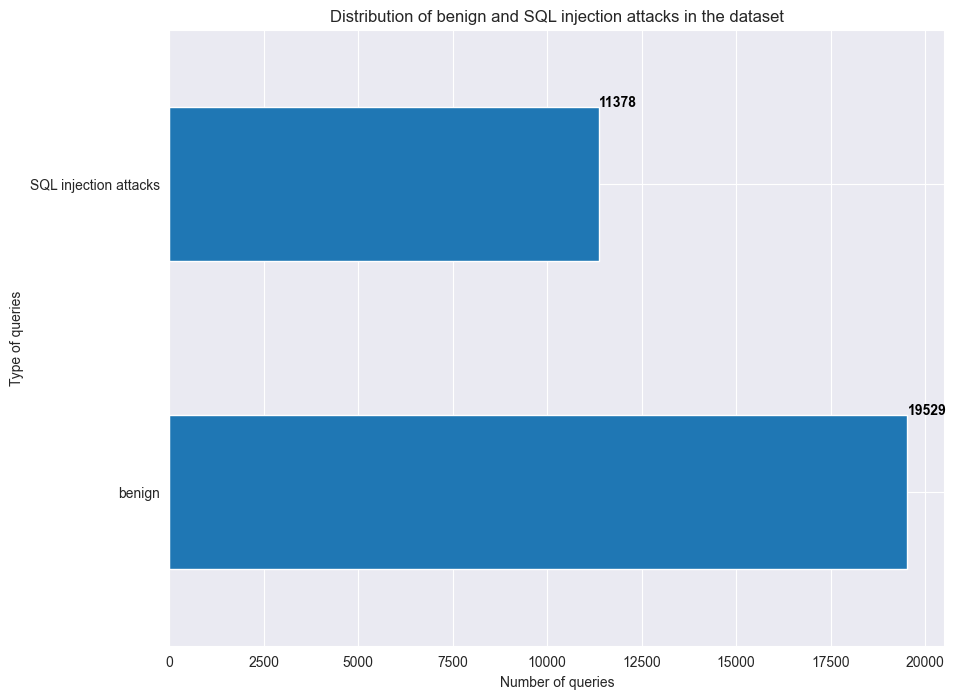

In [8]:
count_target = df['Label'].value_counts()
target_type = df['Label'].dtype

print('Repartition of the target:\n', count_target)
print('\nType of this variable:', target_type)

# plot the distribution of benign and SQL injection attacks in the dataset
plt.figure(figsize=(10, 8))
plt.title('Distribution of benign and SQL injection attacks in the dataset')
ax = count_target.plot(kind='barh')
ax.set_xlabel('Number of queries')
ax.set_ylabel('Type of queries')
for i, v in enumerate(count_target):
    ax.text(v + 3, i + .25, str(v), color='black', fontweight='bold')

# change 0 and 1 by benign and SQL injection attacks
ax.set_yticklabels(['benign', 'SQL injection attacks'])


## 2 - Pre-processing

In [9]:
from sklearn.model_selection import train_test_split

First, we make a copy of the original datasets.

In [10]:
df_copy = df.copy()

We can finally build the matrices X and y for the train and  test sets

In [11]:
X = df['Query']
y = df['Label']

# Tokenize the query column

This step is very important because it allows us to convert the text data into numerical data that can be used by machine learning and deep learning models. Otherwise, the models won't be able to understand the text data.
We have several methods to tokenize the text data, we can use the Tokenizer, TF-IDF vectorizer or any other method. We will use the Tokenizer from keras as it is sufficient for our work.

In [12]:
# import the necessary libraries
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# convert the queries to a list
queries = df['Query'].tolist()

# preprocess the queries
processed_queries = []
padded_sequences = []
for query in queries:
    # convert to lowercase
    query = query.lower()

    # tokenization
    tokens = query.split()

    # join the tokens
    processed_query = ' '.join(tokens)

    # append to the list
    processed_queries.append(processed_query)

# convert text to sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(processed_queries)
sequences = tokenizer.texts_to_sequences(processed_queries)

# pad the sequences
padded_sequences = pad_sequences(sequences, maxlen=50)

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)



# Split the dataset into train and test sets

In [14]:
import os.path

if os.path.exists('trained_model_sql_injection.pickle'):
    print('Loading trained model...')
    model = pickle.load(open('trained_model_sql_injection.pickle', 'rb'))
    print("*************************************************************************")
    print("Model loaded, you can now go to the last cell to make a prediction")
    print("*************************************************************************")
else:
    print('Creating and training a new model...')
    print("Run all the cells below")

Creating and training a new model...
Run all the cells below


In [32]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)
# print the shape of the train and test sets
print('Shape of train set:', X_train.shape)
print('Shape of test set:', X_test.shape)

Shape of train set: (24725, 50)
Shape of test set: (6182, 50)


In [33]:
print(X_train)

[[    0     0     0 ...  3375  3375  3375]
 [    0     0     0 ...    30    18     3]
 [    0     0     0 ...     1    79  2217]
 ...
 [    0     0     0 ...  1099   108     3]
 [    0     0     0 ...     0     0 22345]
 [    0     0     0 ...    19    47    65]]


In the train set, we have now 50 columns which corresponds to each word in the queries that hhave been tokenized in addition of the zero padding.

# Test with several machine learning models

Our first thought was to use a simple machine learning to predict the target variable. We will use several algorithms and compare their accuracy to choose the best one.

In [34]:
# create an Machine learning algorithm to predict the target variable
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
    
# create a dictionary of models
models = {'Logistic Regression': LogisticRegression(),
          'Random Forest': RandomForestClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Support Vector Machine': SVC(),
          'K-Nearest Neighbors': KNeighborsClassifier()}

# create a function to train and evaluate the models
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    # train the model
    model.fit(X_train, y_train)

    # make predictions
    y_pred = model.predict(X_test)

    # print the accuracy score
    print('Accuracy:', accuracy_score(y_test, y_pred), '\n')

    # print the confusion matrix
    print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred), '\n')

    # print the classification report
    print('Classification Report:\n', classification_report(y_test, y_pred))

    # apply k-fold cross validation
    accuracies = cross_val_score(estimator=model, X=X_train, y=y_train, cv=10)
    print('10-fold Cross Validation:\n', accuracies.mean())
    
# train and evaluate the models
for name, model in models.items():
    print(name, '\n')
    train_and_evaluate(model, X_train, y_train, X_test, y_test)
    print('=====================================================================')

Logistic Regression 
Accuracy: 0.7576835975412488 

Confusion Matrix:
 [[3671  241]
 [1257 1013]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.94      0.83      3912
           1       0.81      0.45      0.57      2270

    accuracy                           0.76      6182
   macro avg       0.78      0.69      0.70      6182
weighted avg       0.77      0.76      0.74      6182
10-fold Cross Validation:
 0.7582600990372397
Random Forest 
Accuracy: 0.9949854416046587 

Confusion Matrix:
 [[3894   18]
 [  13 2257]] 

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3912
           1       0.99      0.99      0.99      2270

    accuracy                           0.99      6182
   macro avg       0.99      0.99      0.99      6182
weighted avg       0.99      0.99      0.99      6182
10-fold Cross Validation:
 0.9952680044807547
Decision Tree 

In [35]:
# save the best accuracy model using pickle
import pickle

# save the model to disk
filename = 'ml_model.pickle'
pickle.dump(models['Random Forest'], open(filename, 'wb'))

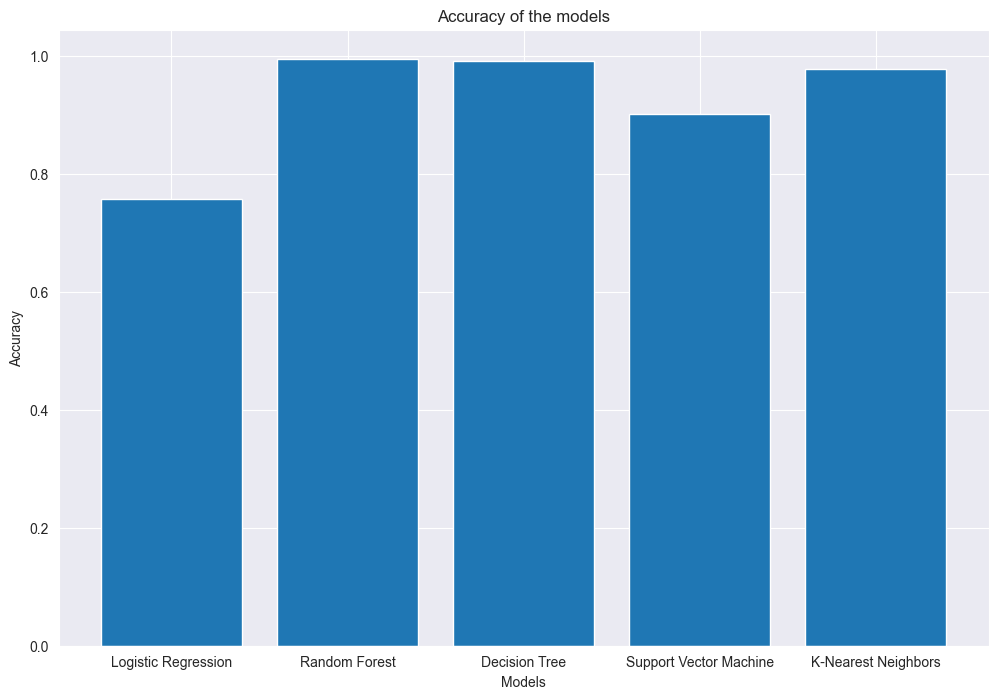

In [36]:
# plot the accuracy of the models
plt.figure(figsize=(12, 8))
plt.title('Accuracy of the models')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.bar(list(models.keys()), [accuracy_score(y_test, model.predict(X_test)) for model in models.values()])
plt.show()

We can see that the best accuracy is obtained with the Random Forest algorithm. We could use it to predict the target variable. However, to use a model in out API, we need to save it as hdf5 file. As we didn't succeed to save the Random Forest model as hdf5 file, we will use a deep neural network model with keras.

# Test with a deep neural network model with keras

We create a simple DNN model with keras, then we fit it on the train set and evaluate it on the test set. Finally we save the model to use it in our web application.

In [73]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Flatten
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

# define input sequence shape
sequence_length = X_train.shape[1]

# define the model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=sequence_length))
model.add(Dropout(0.5))  # add dropout
model.add(Flatten())
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))  # add L2 regularization

# compile the model
opt = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# save history
history = model.fit(X_train, y_train, epochs=30, batch_size=64, verbose=1, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/30
387/387 [==============================] - 9s 22ms/step - loss: 0.3083 - accuracy: 0.9031 - val_loss: 0.1677 - val_accuracy: 0.9777
Epoch 2/30
387/387 [==============================] - 7s 19ms/step - loss: 0.1383 - accuracy: 0.9833 - val_loss: 0.1234 - val_accuracy: 0.9824
Epoch 3/30
387/387 [==============================] - 7s 19ms/step - loss: 0.1065 - accuracy: 0.9894 - val_loss: 0.1049 - val_accuracy: 0.9867
Epoch 4/30
387/387 [==============================] - 7s 19ms/step - loss: 0.0908 - accuracy: 0.9904 - val_loss: 0.0925 - val_accuracy: 0.9909
Epoch 5/30
387/387 [==============================] - 7s 19ms/step - loss: 0.0796 - accuracy: 0.9920 - val_loss: 0.0842 - val_accuracy: 0.9909
Epoch 6/30
387/387 [==============================] - 8s 21ms/step - loss: 0.0722 - accuracy: 0.9920 - val_loss: 0.0784 - val_accuracy: 0.9916
Epoch 7/30
387/387 [==============================] - 9s 22ms/step - loss: 0.0663 - accuracy: 0.9929 - val_loss: 0.0737 - val_accuracy: 0.9914

In [74]:
# Save the model
model.save('dl_model.h5')

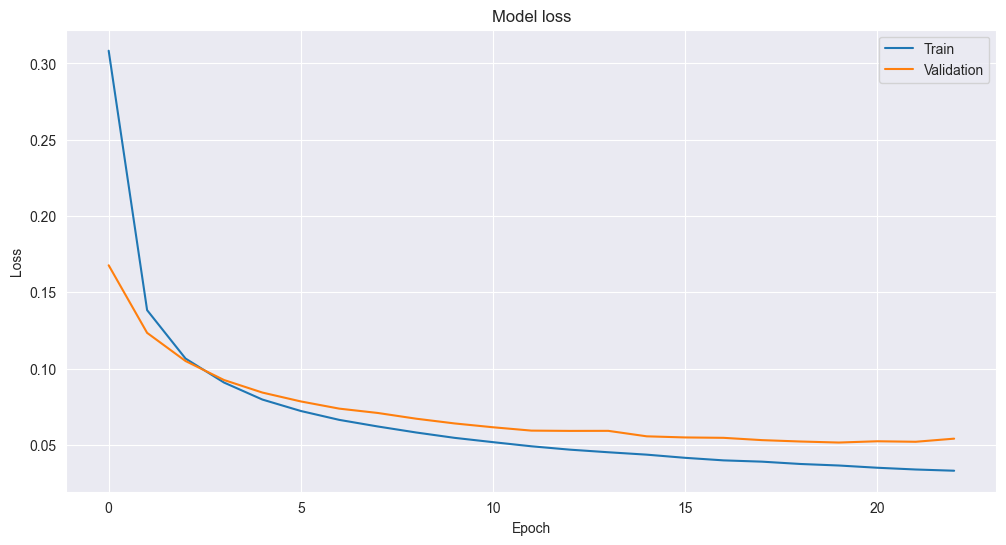

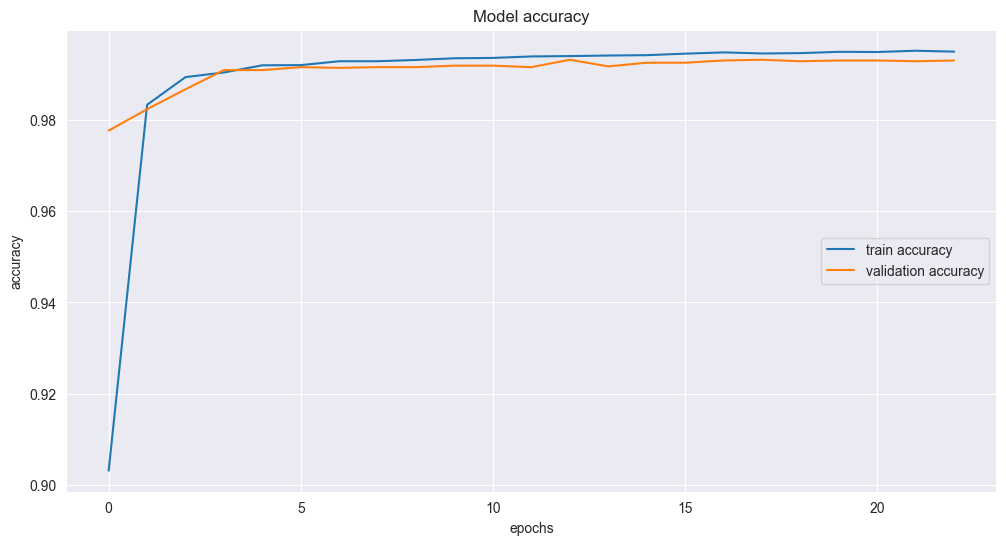

In [75]:
# Import the necessary library
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


# Afficher l'historique de l'accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train accuracy', 'validation accuracy'], loc='right')
plt.show()


In [76]:
# import necessary libraries
from keras.preprocessing.sequence import pad_sequences

# define the SQL statement
sql_statement = "SELECT * FROM employees WHERE department = 'Sales'"
sql_statement2 = "SELECT ItemName, ItemDescription FROM Items WHERE ItemNumber = 999 or 1=1"

# preprocess the SQL statement
# convert to lowercase
sql_statement = sql_statement.lower()
sql_statement2 = sql_statement2.lower()

# tokenize
tokens = sql_statement.split()
tokens2 = sql_statement2.split()

# join the tokens
processed_query = ' '.join(tokens)
processed_query2 = ' '.join(tokens2)

# convert text to sequences
sequences = tokenizer.texts_to_sequences([processed_query])
sequences2 = tokenizer.texts_to_sequences([processed_query2])

# pad the sequences
padded_sequences = pad_sequences(sequences, maxlen=50)
padded_sequences2 = pad_sequences(sequences2, maxlen=50)

# make prediction
prediction = model.predict(padded_sequences)
prediction2 = model.predict(padded_sequences2)

if (prediction > 0.5):
    statement = 'SQL injection attack'
else:
    statement = 'benign'

if (prediction2 > 0.5):
    statement2 = 'SQL injection attack'
else:
    statement2 = 'benign'

# print the prediction
print('Prediction:', prediction, 'The request is :', statement)
print('Prediction:', prediction2, 'The request is :', statement2)

1/1 [==============================] - 0s 24ms/step
Prediction: [[0.00908095]] The request is : benign
Prediction: [[0.99325943]] The request is : SQL injection attack


We are testing the precision of our model

In [77]:
# test the precision of our model
from sklearn.metrics import precision_score

# make predictions
y_pred = model.predict(X_test)

# convert the predictions to binary
y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]

# print the precision score
print('Precision:', precision_score(y_test, y_pred))

194/194 [==============================] - 0s 1ms/step
Precision: 0.995549621717846


The dataset is not so complex, so the model gives good results with a good precision.